## Interpreting indoor positioning as neural machine translation (NMT) problem

This repository is meant as final project after having attended CS224N (Deep Learning for Natural Language Processing).
Instead of targeting a dedicated NLP problem, the goal of this project is to apply the learned ideas to a different domain - indoor positioning.

### Introduction to indoor positioning
Since GNSS positioning (known from outdoors) does not work within building, identifying alternative localization methods has been a research subject over the last couple of years. The field recently received new momentum, since deep learning based approaches have become the goto standard for tackling several open questions in the field, including WLAN fingerprinting (static absolute positioning), directly inferring relative position changes from inertial measurement units (IMU) instead of applying conventional dead reckoning, and many others.

Most accurate positioning can be achieved by fusing several methods, especially those that deliver absolute position estimates (probably at a lower sampling frequency) with the ones that provide relative position updates (obtained at a much higher sampling frequency). Common candidates for absolute estimates are fingerprinting based approaches. Given a set of previously collected fingerprints labeled with the position of collection, a model can be trained in a supervised setting to predict the position for unseen fingerprints. A fingerprint is defined as the observable sensor information, which in case of WLAN fingerprinting is often defined as the received signal strength (RSS) to all observable access points at the given location.

In contrast, relative positioning can be achieved via the IMU (installed in all smartphones). By detecting steps and direction changes, a pedestrian dead reckoning method can be implemented. Recently, it has been demonstrated that via deep learning relative position updates can be directly learned from labeled IMU data.

A common challenge remains to fuse absolute and relative estimates, which is traditionally done via state estimation models (e.g. Kalman filter or Particle Filter).

We try to interpret the problem from the perspective of neural machine translation.

### Model definition
We regard a sequence of IMU measurements and a sequence of WLAN fingerprints as source sentences (of fixed length), which we try to translate into a sequence of position estimates. This allows for modelling the problem via an NLP sequence based encoder/decoder model. We define a sequence of IMU measurements of size T as $\mathbf{X} = (\mathbf{x}_1,...,\mathbf{x}_T)$, where each $\mathbf{x}_i \in \mathbb{R}^9$ contains 3-dimensional accelerometer, gyroscope and magnetometer measurements.

Within such a sequence of T IMU measurements, we assume to have observed M fingerprints (M might differ from sequence to sequence, since the sampling frequency is not fixed in contrast to IMU). A fingerprint is defined as $\mathbf{f} = (f_1, ..., f_M)$ where $f_i$ is the received signal strength (RSS) to the i-th access point. Note that the mapping from indices to APs is fixed and A represents the total amount of observed APs within the dataset.

We use two separate encoder branches for IMU and fingerprints due to their largely different sampling frequency. We also experimented with merging $\mathbf{X}$ and $\mathbf{f}$ by extending $\mathbf{f}$ into the time-domain (synched with the sequence length T). However, the resulting tensor of shape $(T, 9 + A)$ is really sparse along the time-axis for the fingerprints, which makes extracting knowledge on the absolute location impossible.
Instead, we use bidirectional LSTMs for encoding both measurement sequences individually. We thus obtain hidden states of the IMU-encoder as
$$\mathbf{h}^{IMU}_i = [\overleftarrow{\mathbf{h}^{IMU}_i}, \overrightarrow{\mathbf{h}^{IMU}_i}] \text{ where } \mathbf{h}^{IMU}_i \in \mathbb{R}^{2h\times 1}$$
and cell states as
$$\mathbf{c}^{IMU}_i = [\overleftarrow{\mathbf{c}^{IMU}_i}, \overrightarrow{\mathbf{c}^{IMU}_i}] \text{ where } \mathbf{c}^{IMU}_i \in \mathbb{R}^{2h\times 1}$$

Similarly, the hidden and cell states of the fingerprint encoder are given as
$$\mathbf{h}^{F}_i = [\overleftarrow{\mathbf{h}^{F}_i}, \overrightarrow{\mathbf{h}^{F}_i}] \text{ where } \mathbf{h}^{F}_i \in \mathbb{R}^{2h\times 1}$$
and
$$\mathbf{c}^{F}_i = [\overleftarrow{\mathbf{c}^{F}_i}, \overrightarrow{\mathbf{c}^{F}_i}] \text{ where } \mathbf{c}^{F}_i \in \mathbb{R}^{2h\times 1}$$

We then initialize the decoder with a linear projection of the concatenation of the hidden states of both encoders
$$\mathbf{h}^{dec}_0 = \mathbf{W}_h [\overleftarrow{\mathbf{h}^{IMU}_1}, \overleftarrow{\mathbf{h}^{IMU}_T}, \overleftarrow{\mathbf{h}^{F}_1}, \overrightarrow{\mathbf{h}^{F}_M}] \text{ where } \mathbf{W}_h \in \mathbb{R}^{h \times 4h}$$
and the cell states as
$$\mathbf{c}^{dec}_0 = \mathbf{W}_c [\overleftarrow{\mathbf{c}^{IMU}_1}, \overleftarrow{\mathbf{c}^{IMU}_T}, \overleftarrow{\mathbf{c}^{F}_1}, \overrightarrow{\mathbf{c}^{F}_M}] \text{ where } \mathbf{W}_c \in \mathbb{R}^{h \times 4h}$$

We assume a fixed target length of O < T. Thus, we artificially lower the output frequency of the model. We then define our target vector as $\mathbf{Y} = (\mathbf{y}_1; ...; \mathbf{y}_O)$, where each $\mathbf{y}_o = (x_o, y_o)$ is a two-dimensional position.
We feed the t-th target coordinate to the model decoder. Note that a start token is added to the target sequence. Furthermore, the target coordinate $\mathbf{y}_t$ is concatenated with the combined output vector of the previous decoder output $\mathbf{o}_{t-1}$ (initialized as zero vector for the initial decoder step) to produce $\overline{\mathbf{y}_t} \in \mathbb{R}^{(2+h)\times 1}$.

$\overline{\mathbf{y}_t}$ is the fed to the decoder as follows:

$$\mathbf{h}^{dec}_t, \mathbf{c}^{dec}_t = Decoder(\overline{\mathbf{y}_t}, \mathbf{h}^{dec}_{t-1}, \mathbf{c}^{dec}_{t-1})$$

We only compute cross attention to the IMU encoder hidden states, since M will be small (<=3 for T=400). We thus compute multiplicative attention over the IMU encoder hidden states as
$$\mathbf{e}_{t,i} = (\mathbf{h}^{dec}_t$)^T\mathbf{W}_{attProj}\mathbf{h}^{enc}_i \text{ where } \mathbf{e}_t \in \mathbb{R}^{T \times 1}, \mathbf{W}_{attProj} \in \mathbb{R}^{h\times 4h$$
$$\alpha_t = softmax(\mathbf{e}_t) \text{ where } \alpha_t \in \mathbb{R}^{T \times 1}$$
$$\mathbf{a}_t = \sum_{i=1}^T \alpha_{t,i}\mathbf{h}^{enc}_i \text{ where } \mathbf{a}_t \in \mathbb{R}^{4h\times 1}$$

We then compute a linear projection of the concatenation of the attention output and the decoder hidden state, apply a non-linear activation and utilize a dropout layer.
$$\mathbf{u}_t = (\mathbf{a}_t;\mathbf{h}^{dec}_t) \text{ where } \mathbf{u}_t \in \mathbb{R}^{3h\times 1}$$
$$\mathbf{v}_t = \mathbf{W}_u\mathbf{u}_t \text{ where } \mathbf{v}_t \in \mathbb{R}^{h \times1}, \mathbf{W}_u \in \mathbb{R}^{h \times 3h}$$
$$\mathbf{o}_t = dropout(tanh(\mathbf{v}_t)) \text{ where } \mathbf{o}_t \in \mathbb{R}^{h\times 1}$$

Finally, we compute a linear transformation of the combined output to obtain the target prediction (coordinates) at step t as
$$\mathbf{P}_t = \mathbf{W}_{target}\mathbf{o}_t \text{ where } \mathbf{P}_t \in \mathbb{R}^{2 \times 1}, \mathbf{W}_{target} \in \mathbb{R}^{2 \times h}$$

#### Network training
The network can be trained by using standard mean squared error loss.
Additionally, we experimented with a custom loss function that also penalizes the relative changes among the predicted trajectory with respect to the target trajectory.

The relative changes are computed as follows. Given $(\mathbf{y}_i; ...; \mathbf{y}_{i+1})$ and $(\mathbf{p}_i; ..., \mathbf{p}_{i+1})$, we move the initial point to the origin to obtain the vectors $\mathbf{p}_{i\rightarrow i+1} = \mathbf{p}_{i+1} - \mathbf{p}_i$ and $\mathbf{y}_{i\rightarrow i+1} = \mathbf{y}_{i+1} - \mathbf{y}_i$.
We the compute the dot product between those vectors $d_{i\rightarrow i+1} = (\mathbf{p}_{i\rightarrow i+1})^T \mathbf{y}_{i\rightarrow i+1}$ to capture angular and the magnitudal differences. We then obtain the combined loss as
$$\mathcal{L} = -\sum_{i=1}^{O-1} d_{i\rightarrow i+1} + MSE(\mathbf{Y} - \mathbf{P})$$

#### Dataset

We utilize the [giaIndoorLoc](https://doi.org/10.5281/zenodo.6801310) dataset for training our model. The dataset contains several trajectories of collected data that include the WLAN fingerprints (with roughly 3-5s between consecutive samples) and IMU measurements every 20ms. Each data entry is labeled with the true position of collection. We use T=200, such that M $\in$ [0,3]. We utilize padded tensors for modelling the variable sequence length M. The target output length is set to 0=10 and we artificially enlarge our dataset by generating step-wise (10) shift for obtaining the various input/output sequences.

### Example of training the model and generating a few predictions

In [19]:
from data_provider import get_multi_source_data, scale_imu_data
from visualization import visualize_predictions
from model import MultiSourceCrossAttention, MultiSourceEncoder
from loss import custom_loss
import numpy as np
import torch
import torch.nn as nn

from utils import batch_iter_no_tensor

In [20]:
print("Prepare input data...")
imu, rss, pos = get_multi_source_data(devices=['S20', 'OnePlus', 'Galaxy'],
                                      seq_length=200, step_size=10, output_step_size=20)

# ignore relative position of wlan scan within window for now
rss = [r[0] for r in rss]

# scale imu data
imu = scale_imu_data(imu)

# scale rss data
max_rss = -40.0
min_rss = -110.0
rss = [(r - min_rss) / (max_rss - min_rss) for r in rss]

train_data = list(zip(imu, rss, pos))

Prepare input data...


In [21]:
print("Start training of model...")
save_path = "CrossAttention_loss.pt"
device = "cpu"
num_epochs = 5
loss_fnc = custom_loss # nn.MSELoss(reduction='mean')

model = MultiSourceEncoder(num_imu=9, num_ap=np.shape(rss[0])[1], hidden_size=256, loss_fnc=loss_fnc)

model.train()

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_iter = epoch = 0

while epoch < num_epochs:
    epoch += 1

    for src_imu, src_rss, tgt in batch_iter_no_tensor(train_data, batch_size=32, shuffle=True):
        train_iter += 1

        optimizer.zero_grad()

        loss, _ = model(src_imu, src_rss, tgt)

        loss.backward()

        optimizer.step()

        if train_iter % 10 == 0:
            print(loss)

        #if train_iter % 100 == 0:
        #    break

    print("epoch {} finished with loss: {}".format(epoch, loss))

torch.save(model.state_dict(), save_path)

Start training of model...
tensor(1818.1042, grad_fn=<AddBackward0>)
tensor(1403.5555, grad_fn=<AddBackward0>)
tensor(1297.2963, grad_fn=<AddBackward0>)
tensor(1151.5571, grad_fn=<AddBackward0>)
tensor(954.2758, grad_fn=<AddBackward0>)
tensor(877.7987, grad_fn=<AddBackward0>)
tensor(1151.8643, grad_fn=<AddBackward0>)
tensor(627.1101, grad_fn=<AddBackward0>)
tensor(680.6522, grad_fn=<AddBackward0>)
tensor(668.8578, grad_fn=<AddBackward0>)
tensor(709.1912, grad_fn=<AddBackward0>)
tensor(589.3196, grad_fn=<AddBackward0>)
tensor(654.4160, grad_fn=<AddBackward0>)
tensor(613.2604, grad_fn=<AddBackward0>)
tensor(573.7097, grad_fn=<AddBackward0>)
tensor(591.0629, grad_fn=<AddBackward0>)
tensor(575.3416, grad_fn=<AddBackward0>)
tensor(685.1325, grad_fn=<AddBackward0>)
tensor(600.6257, grad_fn=<AddBackward0>)
tensor(590.0719, grad_fn=<AddBackward0>)
tensor(837.7607, grad_fn=<AddBackward0>)
tensor(677.5881, grad_fn=<AddBackward0>)
tensor(969.3312, grad_fn=<AddBackward0>)



KeyboardInterrupt



Visualize 5 example predictions...


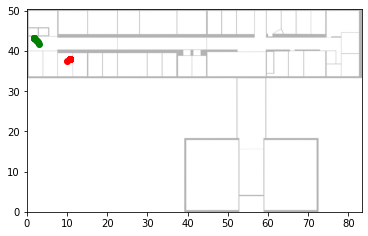

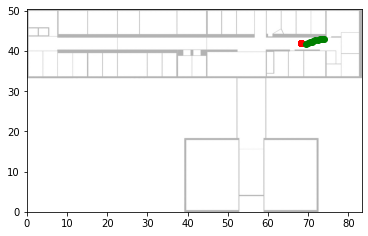

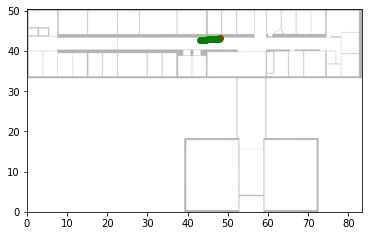

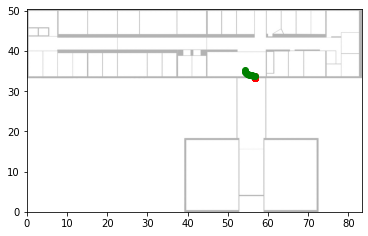

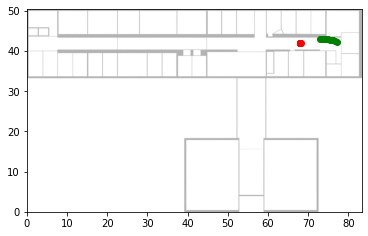

In [17]:
print("Visualize 5 example predictions...")
model.load_state_dict(torch.load(save_path))
model.eval()
with torch.no_grad():
    for src_imu, src_rss, tgt in batch_iter_no_tensor(train_data, batch_size=32, shuffle=True):

        tgt = torch.Tensor(tgt)

        # uses predictions as input for decoder
        _, pred = model(src_imu, src_rss, tgt)

        visualize_predictions(tgt[:5, 1:, :], pred[:5, :-1, :])

        break

#### Results

This project only servers as a proof of concept for applying neural machine translation models for sequential indoor positioning and for strengthening the understanding of current NLP models. Therefore, we do not provide a formal evaluation and comparison of the developed models. We note that any model having a separate encoder for the WLAN fingerprints is capable of extracting the absolute position via the fingerprint decoder, however, there are still problems in the decoding shape of the trajectory. It should be able to capture the shape through the movement relatively encoded within the IMU decoder hidden states, which is currently not always achieved. Furthermore, the model has trouble to extract the absolute position from the WLAN encoder hidden state. The loss will stagnate at the state where the model always outputs the mean position. However, eventually it often finds a way to further decrease the loss but this is not always guaranteed.

#### Alternative implementations

We have implemented various variations of the model architecture. Initially we merged both input data sources by extending the fingerprints in the time-domain. This allows for using a single encoder on the joint input data. However, the sparseness in the time domain prevents the model from properly extracting the global location from the fingerprints. Furthermore, since the number of fingerprints per sequence is quite small, we tried to map it into a single fingerprint by utilizing the most recent RSS value for APs observed multiple time during the sequence. We also implemented a baseline method to check whether the absolute position can be extracted from the fingerprints only.

### Acknowledgements

The code and the model architecture of the encoder/decoder model (LSTM with attention) is heavily inspired by assignment 4 of CS224n.